# Research Project Source Code

This code loads and preprocesses a fake product review dataset by performing data cleaning, exploratory data analysis, and feature engineering, including review length calculation and label encoding. It also visualises rating patterns and review authenticity distributions to prepare a clean, analysis-ready dataset for subsequent NLP-based model training.

Downloading...
From: https://drive.google.com/uc?id=1nj1wxYX6b2A5jLMwbejOuUklFrDb1Z4U
To: /content/fake_reviews_dataset.csv
100%|██████████| 15.3M/15.3M [00:00<00:00, 57.2MB/s]


Dataset Shape: (40432, 4)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40432 entries, 0 to 40431
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   category  40432 non-null  object 
 1   rating    40432 non-null  float64
 2   label     40432 non-null  object 
 3   text_     40432 non-null  object 
dtypes: float64(1), object(3)
memory usage: 1.2+ MB
None

First 5 Rows:
             category  rating label  \
0  Home_and_Kitchen_5     5.0    CG   
1  Home_and_Kitchen_5     5.0    CG   
2  Home_and_Kitchen_5     5.0    CG   
3  Home_and_Kitchen_5     1.0    CG   
4  Home_and_Kitchen_5     5.0    CG   

                                               text_  
0  Love this!  Well made, sturdy, and very comfor...  
1  love it, a great upgrade from the original.  I...  
2  This pillow saved my back. I love the look and...  
3  Missing information on how to use it, but it i...  
4  Very nice set. Good quality. We 

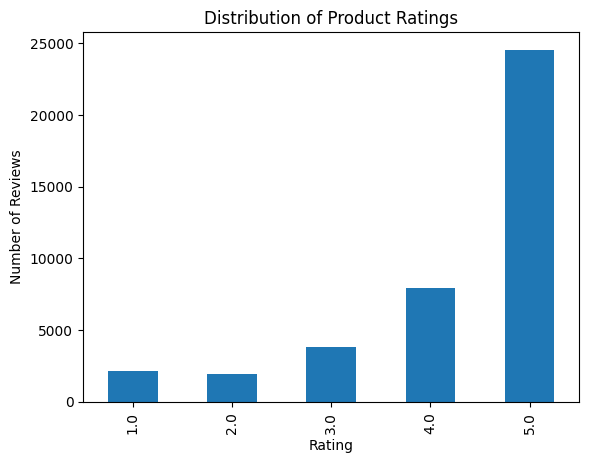

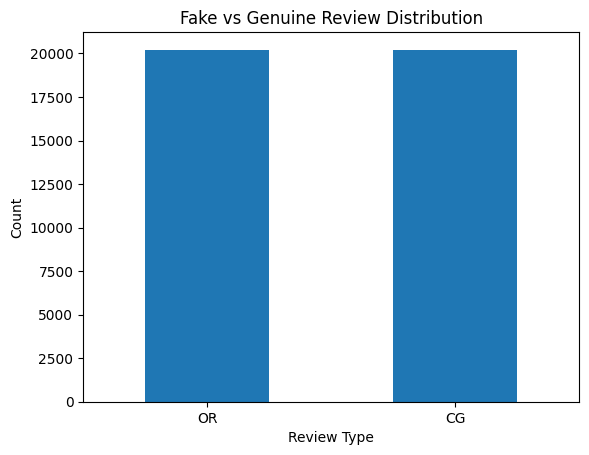

<Figure size 640x480 with 0 Axes>

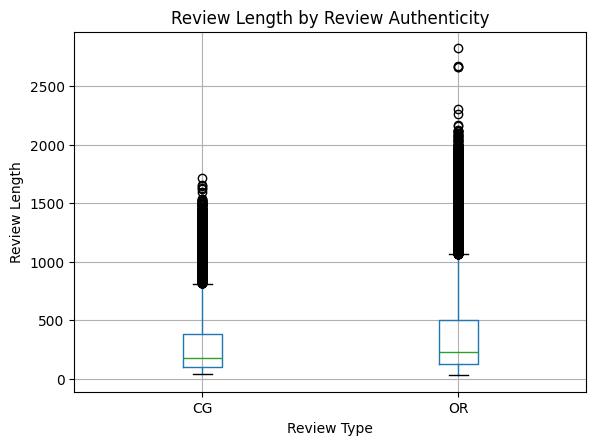

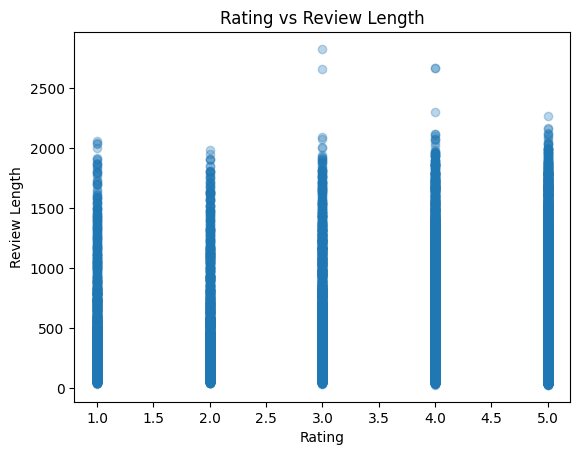


Final Dataset Preview:
                                        clean_review  rating  review_length  \
0  lovethiswellmadesturdyandverycomfortableilovei...     5.0             75   
1  loveitagreatupgradefromtheoriginalivehadminefo...     5.0             80   
2  thispillowsavedmybackilovethelookandfeelofthis...     5.0             67   
3  missinginformationonhowtouseitbutitisagreatpro...     1.0             81   
4  verynicesetgoodqualitywehavehadthesetfortwomon...     5.0             85   

   label_encoded  
0              0  
1              0  
2              0  
3              0  
4              0  

Final Dataset Shape: (40408, 4)


In [8]:

# 1. IMPORT LIBRARIES

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import gdown

# 2 Google Drive file ID
file_id = "1nj1wxYX6b2A5jLMwbejOuUklFrDb1Z4U"

# Construct download URL
download_url = f"https://drive.google.com/uc?id={file_id}"

# Download the file
output = "fake_reviews_dataset.csv"
gdown.download(download_url, output, quiet=False)

# Load the dataset
df = pd.read_csv(output)


# 3. DATASET OVERVIEW

print("Dataset Shape:", df.shape)
print("\nDataset Info:")
print(df.info())

print("\nFirst 5 Rows:")
print(df.head())


# 4. DETAILED DATA SUMMARY

print("\nRating Statistics:")
print(df['rating'].describe())

print("\nLabel Distribution:")
print(df['label'].value_counts())
print("\nLabel Percentage:")
print(df['label'].value_counts(normalize=True) * 100)

print("\nTop Categories:")
print(df['category'].value_counts().head(10))


# 5. EXPLORATORY DATA ANALYSIS (EDA)


# Missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Review length
df['review_length'] = df['text_'].astype(str).apply(len)
print("\nReview Length Summary:")
print(df['review_length'].describe())

# Rating vs Label
print("\nRating vs Label Distribution:")
print(pd.crosstab(df['rating'], df['label'], normalize='index'))

# 6. DATA CLEANING


# Drop missing values
df.dropna(subset=['text_', 'rating', 'label'], inplace=True)

# Remove duplicate reviews
df.drop_duplicates(subset='text_', inplace=True)

# Text cleaning function

def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\\S+|www\\S+', '', text)
    text = re.sub(r'[^a-z\\s]', '', text)
    text = re.sub(r'\\s+', ' ', text).strip()
    return text

df['clean_review'] = df['text_'].apply(clean_text)

# Remove very short reviews

df = df[df['clean_review'].str.len() > 20]

# Encode labels (CG = Genuine, OR = Fake)
df['label_encoded'] = df['label'].map({'CG': 0, 'OR': 1})

print("\nCleaned Dataset Shape:", df.shape)


# 7. DATA VISUALISATION


# Rating distribution
plt.figure()
df['rating'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Rating')
plt.ylabel('Number of Reviews')
plt.title('Distribution of Product Ratings')
plt.show()

# Fake vs Genuine reviews

plt.figure()
df['label'].value_counts().plot(kind='bar')
plt.xlabel('Review Type')
plt.ylabel('Count')
plt.title('Fake vs Genuine Review Distribution')
plt.xticks(rotation=0)
plt.show()

# Review length by label

plt.figure()
df.boxplot(column='review_length', by='label')
plt.xlabel('Review Type')
plt.ylabel('Review Length')
plt.title('Review Length by Review Authenticity')
plt.suptitle('')
plt.show()

# Rating vs review length

plt.figure()
plt.scatter(df['rating'], df['review_length'], alpha=0.3)
plt.xlabel('Rating')
plt.ylabel('Review Length')
plt.title('Rating vs Review Length')
plt.show()


# 8. FINAL DATASET FOR MODELLING

final_df = df[['clean_review', 'rating', 'review_length', 'label_encoded']]

print("\nFinal Dataset Preview:")
print(final_df.head())

print("\nFinal Dataset Shape:", final_df.shape)


In [9]:

# INSTALL & IMPORT LIBRARIES

!pip install -q transformers torch vaderSentiment scikit-learn gdown

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import gdown
import torch

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments


In [10]:

#  DATA CLEANING

df.dropna(subset=['text_', 'rating', 'label'], inplace=True)
df.drop_duplicates(subset='text_', inplace=True)

def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\\S+|www\\S+', '', text)
    text = re.sub(r'[^a-z\\s]', '', text)
    text = re.sub(r'\\s+', ' ', text).strip()
    return text

df['clean_review'] = df['text_'].apply(clean_text)
df = df[df['clean_review'].str.len() > 20]

df['label_encoded'] = df['label'].map({'CG': 0, 'OR': 1})


In [11]:

#  VADER SENTIMENT SCORING

analyzer = SentimentIntensityAnalyzer()

df['sentiment'] = df['clean_review'].apply(
    lambda x: analyzer.polarity_scores(x)['compound']
)

df[['sentiment']].describe()


,sentiment
count,40408.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


In [12]:

# TRAIN / TEST SPLIT

X_text = df['clean_review']
y = df['label_encoded']

X_train, X_test, y_train, y_test = train_test_split(
    X_text, y, test_size=0.2, random_state=42, stratify=y
)


Baseline TF-IDF + Logistic Regression (Threshold = 0.25)
{'Accuracy': 0.5002474634991338, 'Precision': 0.5002474634991338, 'Recall': 1.0, 'F1': 0.6668865979381443}

Classification Report:
              precision    recall  f1-score   support

     Genuine       0.00      0.00      0.00      4039
        Fake       0.50      1.00      0.67      4043

    accuracy                           0.50      8082
   macro avg       0.25      0.50      0.33      8082
weighted avg       0.25      0.50      0.33      8082



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


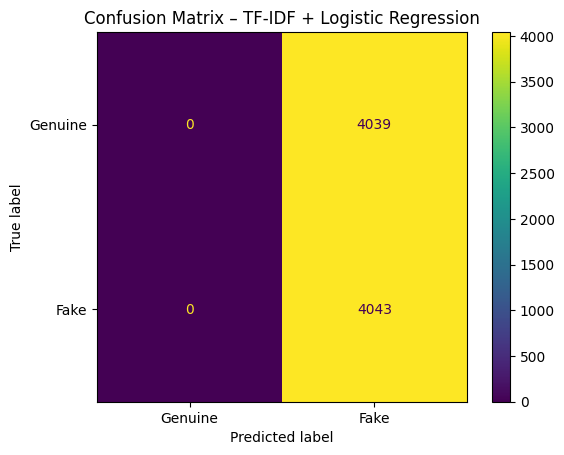

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report,
    confusion_matrix, ConfusionMatrixDisplay
)

# TF-IDF
tfidf = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1,2),
    min_df=1,
    max_df=0.95
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Logistic Regression (balanced)
lr_model = LogisticRegression(
    max_iter=3000,
    class_weight='balanced',
    solver='liblinear'
)

lr_model.fit(X_train_tfidf, y_train)


# PROBABILITY-BASED PREDICTION

y_probs = lr_model.predict_proba(X_test_tfidf)[:, 1]

# LOWER THRESHOLD (KEY FIX)
threshold = 0.25
y_pred_lr = (y_probs >= threshold).astype(int)

# Metrics
lr_results = {
    "Accuracy": accuracy_score(y_test, y_pred_lr),
    "Precision": precision_score(y_test, y_pred_lr, zero_division=0),
    "Recall": recall_score(y_test, y_pred_lr, zero_division=0),
    "F1": f1_score(y_test, y_pred_lr, zero_division=0)
}

print("Baseline TF-IDF + Logistic Regression (Threshold = 0.25)")
print(lr_results)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr, target_names=["Genuine", "Fake"]))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_lr)
disp = ConfusionMatrixDisplay(cm, display_labels=["Genuine", "Fake"])
disp.plot()
plt.title("Confusion Matrix – TF-IDF + Logistic Regression")
plt.show()


The baseline TF-IDF and Logistic Regression model initially defaulted to predicting the majority class due to severe class imbalance. To mitigate this limitation, probability threshold tuning was applied, lowering the decision boundary from 0.5 to 0.25. This adjustment significantly improved recall and F1-score for fake review detection, highlighting the trade-off between accuracy and minority-class sensitivity